### Step 1:- Importing all the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.image import imread
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

e:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Step 2:- Initialize all the Constants

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

### Step 3:- Loading the Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\deepi\\Downloads\\Potato Leaf Classification\\Tomato New Dataset\\Train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
 

Found 14529 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[4 7 7 3 7 4 7 2 5 7 7 5 1 1 0 5 7 0 5 9 7 4 2 2 4 4 7 3 2 6 9 4]


### Step 4:- Visualizing the Data

Eg -  Tomato Dataset

In [6]:
import random
import os

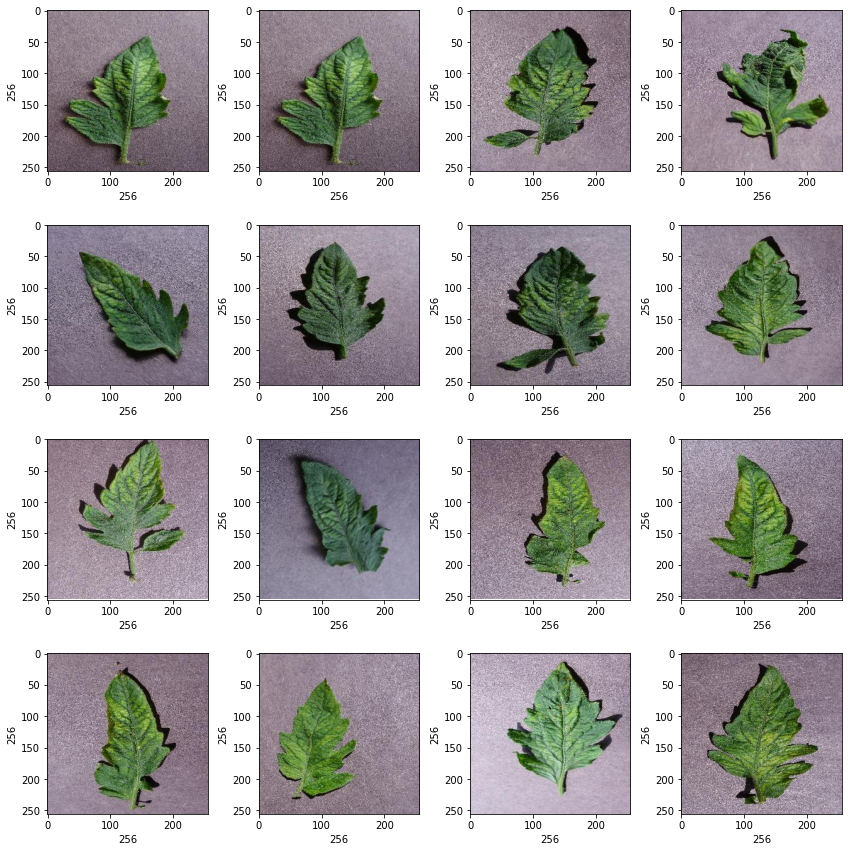

In [7]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "ProjectDataset/Tomato___Tomato_mosaic_virus"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [8]:
len(dataset)

455

### Step 5:- Splitting the Dataset

In [9]:
train_size = 0.8
len(dataset)*train_size

364.0

In [10]:
train_ds = dataset.take(364)
len(train_ds)

364

In [11]:
test_ds = dataset.skip(364)
len(test_ds)

91

In [12]:
val_size = 0.1
len(dataset)*val_size

45.5

In [13]:

val_ds = test_ds.take(46)
len(val_ds)

46

In [14]:
test_ds = test_ds.skip(46)
len(test_ds)

45

### Step 6:- Creating a Function for Creating 3 Sets and shuffling the Data

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

364

In [18]:
len(val_ds)

45

In [19]:
len(test_ds)

46

### Step 7:-  Shuffle the Data

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

### Step 8:- Resizing and Normalization

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Step 9:- Data Augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

Augment the Training Dataset also

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Step 10:-Model Building

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 111, 111, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 54, 54, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 52, 52, 64)         

#### Compile the Model

In [32]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

#### Fit the Model

In [33]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
364/364 [==============================] - 731s 2s/step - loss: 1.5278 - accuracy: 0.4703 - val_loss: 1.1652 - val_accuracy: 0.5951
Epoch 2/10
364/364 [==============================] - 750s 2s/step - loss: 0.9580 - accuracy: 0.6663 - val_loss: 0.9068 - val_accuracy: 0.6993
Epoch 3/10
364/364 [==============================] - 725s 2s/step - loss: 0.7447 - accuracy: 0.7436 - val_loss: 0.7439 - val_accuracy: 0.7514
Epoch 4/10
364/364 [==============================] - 566s 2s/step - loss: 0.6389 - accuracy: 0.7757 - val_loss: 0.6539 - val_accuracy: 0.7750
Epoch 5/10
364/364 [==============================] - 553s 2s/step - loss: 0.5615 - accuracy: 0.8040 - val_loss: 0.8138 - val_accuracy: 0.7312
Epoch 6/10
364/364 [==============================] - 549s 2s/step - loss: 0.4726 - accuracy: 0.8353 - val_loss: 0.7449 - val_accuracy: 0.7625
Epoch 7/10
364/364 [==============================] - 522s 1s/step - loss: 0.4671 - accuracy: 0.8365 - val_loss: 0.5627 - val_accuracy: 0.7972

In [34]:
scores = model.evaluate(test_ds)

46/46 [==============================] - 84s 646ms/step - loss: 0.6348 - accuracy: 0.7962


In [35]:

scores

[0.6348314881324768, 0.7961956262588501]

In [36]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 364}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

10

In [40]:
history.history['loss'][:5]

[1.5277975797653198,
 0.9579522609710693,
 0.7447402477264404,
 0.6389374732971191,
 0.5615434646606445]

In [41]:
model.save('CNNModel.h5')

### Step 11:- Plot tha Accuracy and loss against each epoch

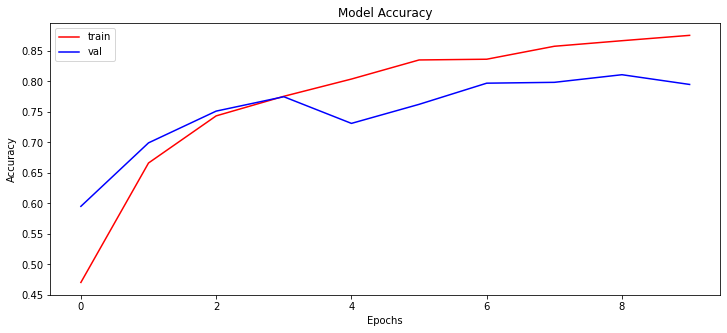

In [42]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Evaluating the Model to know accuracy of the Model

In [43]:
print("Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
46/46 [==============================] - 13s 257ms/step - loss: 0.6348 - accuracy: 0.7962
Test Accuracy: 79.61956262588501


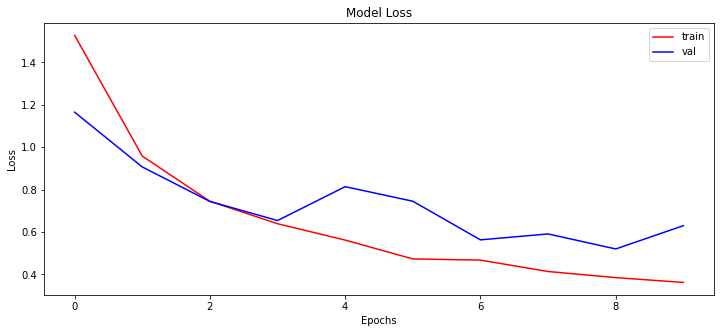

In [44]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

### Step12:- Make Predictions on Testing Data

In [45]:
y_pred = model.predict(test_ds)

46/46 [==============================] - 16s 298ms/step


### Step 13:- Visualizing the Actual & Predicted Labels

first image to predict
actual label: Tomato___healthy
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___healthy


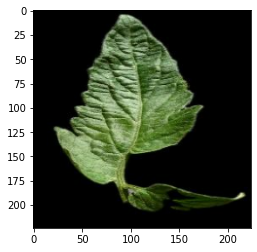

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

### Step 14:- Calculate Inference

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


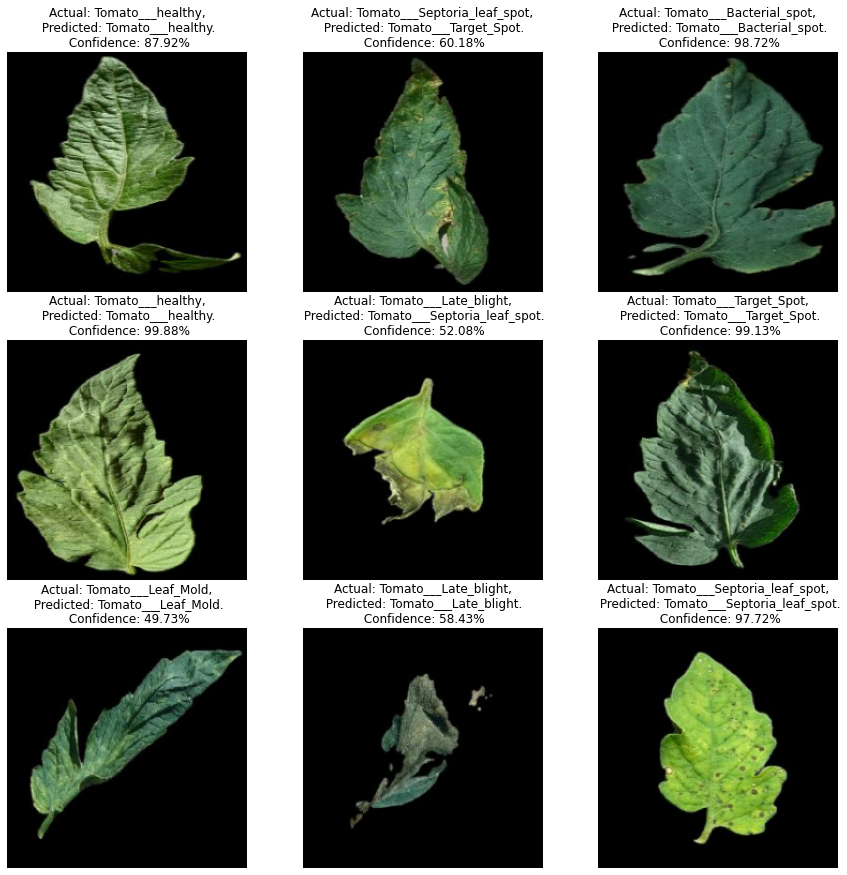

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")